In [1]:
!pip install -q kaggle

import os
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:08<00:00, 217MB/s]
100% 1.06G/1.06G [00:08<00:00, 139MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

csv_path = '/content/drive/MyDrive/Books_rating.csv'

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def load_and_prepare_text_data(file_path,column_name='review/text',max_samples=10000):
    """I upload the csv file
    I prepare a list of cleaned texts from a specific column
    regarding the parameters:
    file_path (str): this is the path to the CSV file containing the reviews
    column_name (str): this is the name of the column containing the text (review/text)
    max_samples (int): this is the maximum number of texts to keep (to limit memory)
    at the end, I return a list of cleaned texts, that is to say a character string"""

    #I load the csv file only with the column of interest
    dataframe =pd.read_csv(file_path,usecols=[column_name])
    #I delete rows with missing values ​​(NaN) in this column
    dataframe =dataframe.dropna()
    #I retrieve the first N texts as a list (up to max_samples)
    cleaned_texts =dataframe[column_name].iloc[:max_samples].tolist()
    return cleaned_texts

def compute_tfidf_matrix(text_data,vocab_limit=1000):
    """I transform a list of texts into a TF-IDF matrix
    for settings:
    text_data (list of str): this is the list of text documents
    vocab_limit (int): this is the maximum number of words retained in the vocabulary (by frequency)
    in the end, I return
    sparse matrix: TF-IDF matrix (n_documents x vocab_limit)"""

    #I configure the TF-IDF vectorizer:
    #max_features limits the number of words
    #stop_words removes unnecessary words in English ("the", "and"...)
    #lowercase forces lowercase
    tfidf_model =TfidfVectorizer(max_features=vocab_limit,stop_words='english',lowercase=True)
    #This is the training of the model and the transformation of texts into TF-IDF vectors
    tfidf_result =tfidf_model.fit_transform(text_data)
    return tfidf_result


#I load and preprocess texts from the CSV file
text_reviews =load_and_prepare_text_data('/content/drive/MyDrive/Books_rating.csv',max_samples=10000)
#This is the calculation of the TF-IDF matrix from the preprocessed texts
tfidf_matrix =compute_tfidf_matrix(text_reviews)
#I displays the shape (dimensions) of the generated TF-IDF matrix
print("TF-IDF matrix shape:",tfidf_matrix.shape)

TF-IDF matrix shape: (10000, 1000)


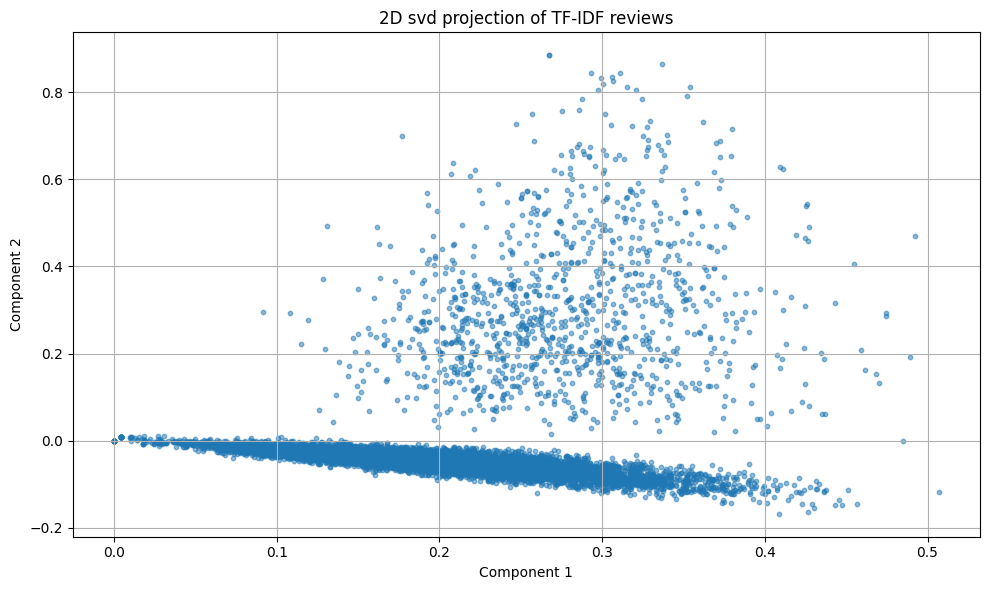

In [5]:
#for svd dimension reduction
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

def reduce_dimensionality_tfidf(tfidf_matrix,target_dims=2,random_state=42):
    """I want to reduce the dimension of the TF-IDF matrix with the Truncated SVD method
    It is analogous to PCA for sparse data
    for my settings:
    tfidf_matrix (sparse matrix): this is the TF-IDF matrix to reduce
    target_dims (int): this is the number of dimensions desired after reduction (default: 2)
    random_state (int): this is the random seed to ensure reproducibility
    at the end I return ndarray: reduced 2D matrix (or target_dims)"""

    #I create the SVD transformer with the target number of dimensions
    svd_transformer =TruncatedSVD(n_components=target_dims,random_state=random_state)
    #I apply dimension reduction to the TF-IDF matrix
    reduced_data =svd_transformer.fit_transform(tfidf_matrix)
    return reduced_data

def plot_2d_projection(data_2d,title="2D svd projection of TF-IDF reviews"):
    """I display a 2D scatter plot of the projected data
    for my settings:
    data_2d (ndarray): this is the 2D matrix where each row is a projected document (SVD)
    title (str): this is the title of the graph"""

    plt.figure(figsize=(10,6))
    plt.scatter(data_2d[:,0],data_2d[:,1],s=10,alpha=0.5)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#I reduce the TF-IDF matrix to 2 dimensions for visualization
projected_text_data =reduce_dimensionality_tfidf(tfidf_matrix)
#I create the visualization of the 2D projection of text documents
plot_2d_projection(projected_text_data)

converged at iteration 19


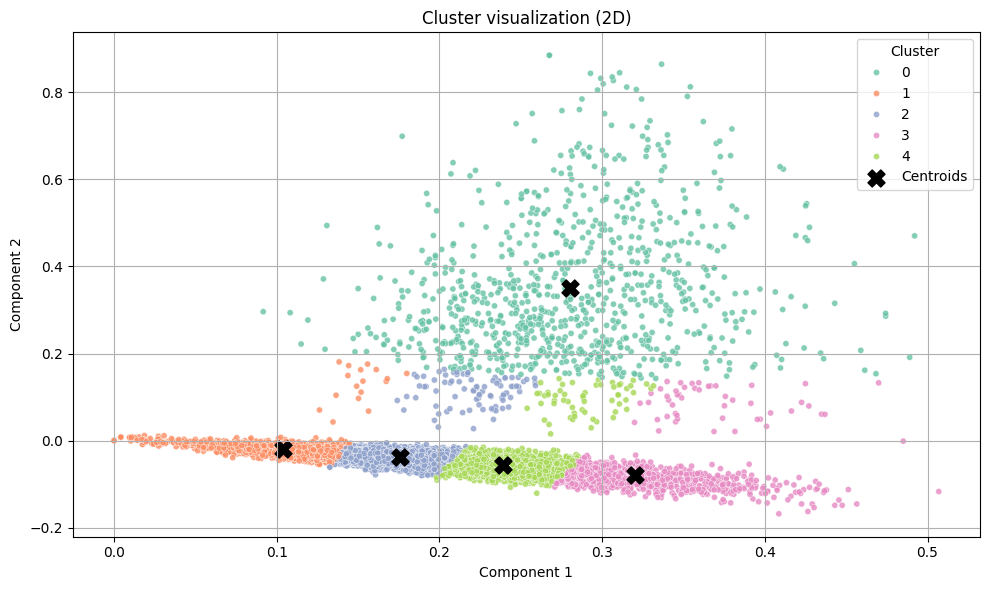

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to calculate distances between points
from sklearn.metrics.pairwise import euclidean_distances

def run_custom_kmeans(data,num_clusters=5,max_iterations=100,convergence_tol=1e-4,seed=42):
    """I implement the K-Means algorithm
    for my settings:
    data (ndarray): this is the matrix containing the data to be grouped
    num_clusters (int): this is the number of clusters to form
    max_iterations (int): this is the maximum number of iterations
    convergence_tol (float): this is the convergence threshold based on the displacement of the centroids
    seed (int): this is the random seed for reproducibility
    in the end I return
    cluster_assignments (ndarray): this is the cluster label assigned to each point
    centroids (ndarray): these are the final coordinates of the centroids"""

    #I initialize the random generator
    np.random.seed(seed)
    #I randomly choose points as initial centroids
    initial_indices =np.random.choice(len(data),num_clusters,replace=False)
    centroids =data[initial_indices]

    for iteration in range(max_iterations):
        #I assign each point to the nearest centroid
        distance_matrix =euclidean_distances(data,centroids)
        cluster_assignments =np.argmin(distance_matrix,axis=1)

        #I recalculate the centroids as the average of the cluster points
        updated_centroids =np.array([
            data[cluster_assignments ==cluster_idx].mean(axis=0)
            #I avoid empty clusters
            if np.any(cluster_assignments ==cluster_idx)
            else centroids[cluster_idx]
            for cluster_idx in range(num_clusters)
        ])
        #I check the convergence (if the centroids no longer move)
        centroid_shift =np.linalg.norm(updated_centroids-centroids,axis=1)
        if np.all(centroid_shift <convergence_tol):
            print(f"converged at iteration {iteration}")
            break

        centroids =updated_centroids
    else:
        print("reached maximum number of iterations without full convergence.")

    return cluster_assignments,centroids

def visualize_clusters(data_2d,cluster_labels,cluster_centers=None,title="Cluster visualization (2D)"):
    """I display the clusters on a 2D graph using seaborn and matplotlib
    for my settings:
    data_2d (ndarray): this is the projected data in 2D
    cluster_labels (ndarray): These are the cluster labels for each point
    cluster_centers (ndarray or None): these are the coordinates of the centroids
    """
    plt.figure(figsize=(10,6))
    #This is the cloud of points colored according to the cluster
    sns.scatterplot(x=data_2d[:,0],y=data_2d[:,1],hue=cluster_labels,palette='Set2',s=20,alpha=0.8,legend='full')

    #I display the centroids if they are available
    if cluster_centers is not None:
        plt.scatter(cluster_centers[:,0],cluster_centers[:,1],c='black',s=150,marker='X',label='Centroids')

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#I checked that the projected data is indeed in 2 dimensions so that it can be plotted.
assert projected_text_data.shape[1] ==2,"input data must be 2-dimensional for visualization"
#I run K-Means on the projected data
num_k =5 #This is the number of clusters I want to have
cluster_labels,cluster_centers =run_custom_kmeans(projected_text_data,num_clusters=num_k)
#I display the result of the clusters
visualize_clusters(projected_text_data,cluster_labels,cluster_centers)

converged at iteration 6
converged at iteration 14
converged at iteration 18
converged at iteration 19
converged at iteration 18
converged at iteration 22
converged at iteration 40
converged at iteration 32
converged at iteration 26


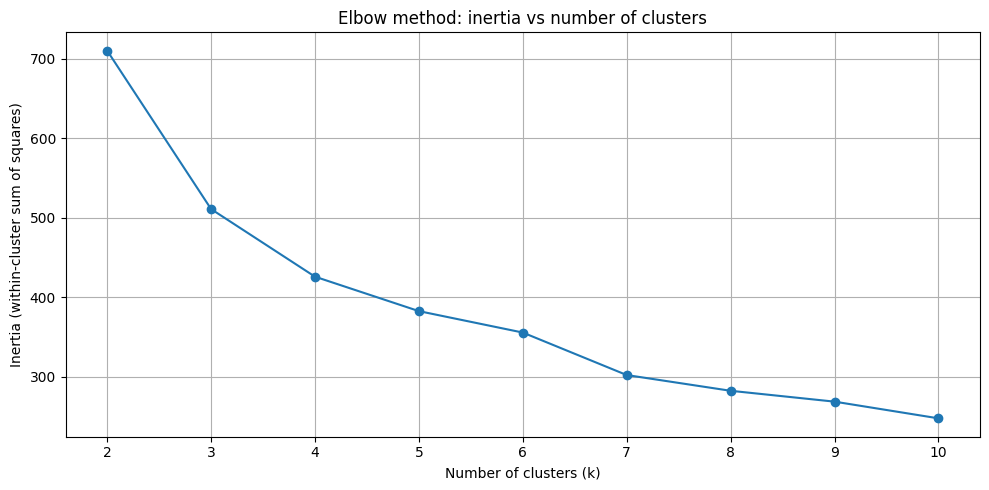

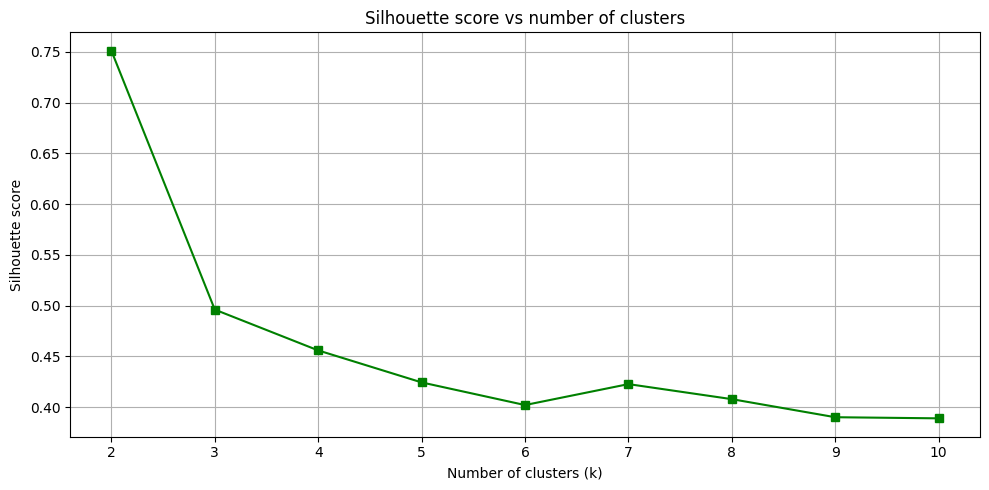

In [7]:
#It is to assess the quality of the clusters
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_kmeans_performance(data,max_clusters=10):
    """I evaluate the performance of K-Means for different values ​​of k by calculating the inertia, i.e. the sum of intra-cluster distances
    I also calculate the silhouette score, that is to say the quality of the separation between clusters
    for my settings:
    data (ndarray): this is the data set (2D) to be grouped
    max_clusters (int): this is the maximum number of clusters to test
    at the end I return a tuple
    k_values ​​(list): this is the list of k values ​​tested
    inertia_list (list): this is the list of corresponding inertias
    silhouette_list (list): this is the list of matching silhouette scores"""

    #my list for storing inertia
    inertia_list =[]
    #my list for storing silhouette scores
    silhouette_list =[]
    #the values ​​of k to test and I start at 2
    k_values =list(range(2,max_clusters +1))

    for k in k_values:
        #I apply k-means with k clusters
        cluster_labels,cluster_centers =run_custom_kmeans(data,num_clusters=k)
        #I calculate the inertia, that is to say the sum of the distances between each point and its centroid
        total_inertia =sum(
            np.linalg.norm(data[cluster_labels == i] -cluster_centers[i],axis=1).sum()
            for i in range(k)
        )
        inertia_list.append(total_inertia)

        #I calculate the silhouette score, if I have at least 2 different clusters
        if len(set(cluster_labels)) >1:
            score =silhouette_score(data,cluster_labels)
            silhouette_list.append(score)
        else:
            #the score is undefined if there is only one cluster
            silhouette_list.append(None)

    return k_values,inertia_list,silhouette_list

def plot_kmeans_evaluation(k_values,inertias,silhouettes):
    """I plot k-means evaluation curves, such as the Elbow (inertia) curve and the silhouette score curve
    for my settings:
    k_values ​​(list): these are the values ​​of k used
    inertias (list): these are the inertias measured for each k
    silhouettes (list): these are the silhouette scores for each k"""

    #I display the Elbow curve, that is to say the inertia as a function of k
    plt.figure(figsize=(10,5))
    plt.plot(k_values,inertias,marker='o')
    plt.title("Elbow method: inertia vs number of clusters")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (within-cluster sum of squares)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #I display the silhouette score curve
    plt.figure(figsize=(10,5))
    plt.plot(k_values,silhouettes,marker='s',color='green')
    plt.title("Silhouette score vs number of clusters")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#I evaluate the performance of k-means on projected (2D) data
k_range,inertia_scores,silhouette_scores =evaluate_kmeans_performance(projected_text_data,max_clusters=10)

#I generate the evaluation graphs
plot_kmeans_evaluation(k_range,inertia_scores,silhouette_scores)

In [ ]:
import pandas as pd
import numpy as np
#for converting text to TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer
#for dimension reduction
from sklearn.decomposition import TruncatedSVD
#for clustering for the first pass
from sklearn.cluster import KMeans
#for distance calculations
from sklearn.metrics.pairwise import euclidean_distances

#my configuration settings for BFR
chunk_size =2000 #This is the number of documents processed per batch.
reduced_dim =20 #This is the target dimension after reduction (SVD)
distance_threshold =1.5 #This is the distance threshold for assigning a point to a cluster
initial_cluster_count =5 #This is the number of clusters for the first batch

#I create a dictionary to store statistics by cluster (DS: discard set)
summary_clusters ={}

def add_point_to_cluster(cluster_index,vector):
    """I update the statistics of a cluster with a new point
    for my settings:
    cluster_index (int): this is the cluster identifier
    vector (ndarray): this is the vector representation of the document"""
    if cluster_index not in summary_clusters:
        #if the cluster does not yet exist, I initialize it
        summary_clusters[cluster_index] ={
            #the shadow of points
            'N':1,
            #the sum of the vectors
            'SUM':vector.copy(),
            #the sum of squares (for variance)
            'SUMSQ':vector **2
        }
    else:
        #I update existing statistics
        summary_clusters[cluster_index]['N'] +=1
        summary_clusters[cluster_index]['SUM'] +=vector
        summary_clusters[cluster_index]['SUMSQ'] +=vector **2

def compute_cluster_centroid_std(cluster_stats):
    """I calculate the centroid and standard deviation for a given cluster
    for my settings:
    cluster_stats (dict): this contains 'N', 'SUM' and 'SUMSQ'
    at the end I return a tuple: centroid (vector), standard deviation (vector)
    """
    N =cluster_stats['N']
    SUM =cluster_stats['SUM']
    SUMSQ =cluster_stats['SUMSQ']
    centroid =SUM/N
    std_dev =np.sqrt((SUMSQ/N)-(centroid**2))
    return centroid,std_dev

#my list to store unassigned points (RS: retained set)
buffered_points =[]
#I read in streaming of the csv, in blocks of lines
text_chunk_reader =pd.read_csv("/content/drive/MyDrive/Books_rating.csv",usecols=["review/text"],chunksize=chunk_size)
#I initialize the TF-IDF vectorizer
tfidf_builder =TfidfVectorizer(max_features=1000,stop_words='english',lowercase=True)
#I train the vocabulary on a small initial sample (500 documents)
initial_sample =pd.read_csv("/content/drive/MyDrive/Books_rating.csv",usecols=["review/text"],nrows=500).dropna()
tfidf_builder.fit(initial_sample["review/text"].tolist())
#I initialized the SVD reducer to go from TF-IDF to a reduced dimension
svd_reducer =TruncatedSVD(n_components=reduced_dim,random_state=42)

#I process each batch of documents
for batch_index, chunk_df in enumerate(text_chunk_reader):
    documents =chunk_df["review/text"].dropna().tolist()
    if not documents:
        continue

    #I do the TF-IDF conversion + dimension reduction
    tfidf_matrix =tfidf_builder.transform(documents)
    reduced_matrix =svd_reducer.fit_transform(tfidf_matrix)

    #I initialize clustering on the first batch
    if batch_index ==0:
        #I use kmeans to initialize the first clusters
        initial_kmeans =KMeans(n_clusters=initial_cluster_count,random_state=42).fit(reduced_matrix)
        for cluster_id in range(initial_cluster_count):
            cluster_vectors =reduced_matrix[initial_kmeans.labels_ ==cluster_id]
            for vec in cluster_vectors:
                #I add it to the cluster
                add_point_to_cluster(cluster_id, vec)
        print("initial cluster summaries created from first data batch")
        #I skip the normal assignment step for this batch
        continue

    #I am taring the following batches: assignment or buffering
    for vec in reduced_matrix:
        is_assigned =False

        for cluster_id,stats in summary_clusters.items():
            centroid,std_dev =compute_cluster_centroid_std(stats)
            #This is the Mahalanobis type standard (simplified,diagonal only)
            distance =np.linalg.norm((vec-centroid)/(std_dev+1e-6))

            if distance<distance_threshold:
                add_point_to_cluster(cluster_id,vec)
                is_assigned =True
                #If I find a nearby cluster, I go out
                break

        if not is_assigned:
            #if it is too far from all clusters, I buffer (RS)
            buffered_points.append(vec)

    print(f"batch {batch_index +1} processed —unassigned points (RS) {len(buffered_points)}")

#I summarize once all the batches have been processed
print(f"\nfinal number of clusters (DS):{len(summary_clusters)}")
print(f"remaining unassigned points (RS):{len(buffered_points)}\n")

#This is a preview of the final cluster centroids (first 5 dimensions only)
for cluster_id,stats in summary_clusters.items():
    preview_centroid =(stats['SUM'] /stats['N'])[:5]
    print(f"cluster {cluster_id} —size:{stats['N']} —centroid preview:{preview_centroid}")